In [1]:
import numpy as np
import os
import PIL.Image
import PIL.ImageFont
import PIL.ImageDraw
import tensorflow as tf
import tensorflow_datasets as tfds
try:
  %tensorflow_version 2.x
except Exception:
  pass
from matplotlib import pyplot as plt
from typing import Optional

print("Tensorflow version "+ tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.15.0


defining bounding boxes

In [2]:
im_width: int = 75
im_height: int = 75
use_normalized_coordinates: bool = True #normalising the yhe coordinates of the bounding box to 0 and 1
'''his function takes an image represented as a numpy array, draws bounding boxes on it, and returns the modified image as a numpy array. .'''
def draw_bounding_boxes_on_image_array(
    image: np.ndarray,
    boxes: np.ndarray, #A 2-dimensional numpy array of shape [N, 4], where each row contains the coordinates of a bounding box in the format (ymin, xmin, ymax, xmax).
    color: list = [],
    thickness: int = 1 ,
    display_str_list: list=[],) -> np.ndarray:

    image_pil: PIL.Image.Image = PIL.Image.fromarray(image)
    rgbimg: PIL.Image.Image = PIL.Image.new("RGBA", image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg, boxes , color , thickness, display_str_list)
    return np.array(rgbimg)#returns the result as a numpy array.









In [33]:
from PIL import Image, ImageDraw


In [34]:
'''this function facilitates drawing multiple bounding boxes on a PIL image based on the input bounding box coordinates, with optional customization of colors, thickness, and display strings for each bounding box'''

def draw_bounding_boxes_on_image(
    image:PIL.Image.Image ,
    boxes: np.ndarray ,
    color: list = [] ,
    thickness: int = 1,
    display_str_list = []
) -> None:
    boxes_shape: tuple[int] = boxes.shape     #checking if shape of 'boxes' array is not empty
    if not boxes_shape:
      return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
      raise ValueError('INput must be of size [N, 4]')
    for i in range(boxes_shape[0]):
      draw_bounding_box_on_image(
          image,
          boxes[i,1],
          boxes[i,0],
          boxes[i,3],
          boxes[i,2],
          color[i],
          thickness ,
          display_str_list[i]

      )

def draw_bounding_box_on_image(
    image: PIL.Image.Image,
    ymin: np.float32,
    xmin: np.float32,
    ymax: np.float32,
    xmax: np.float32,
    color: str = 'red',
    thickness: int = 1,
    display_str: Optional[str]=None,
    use_normalized_coordinates: bool = True
) -> None:
    draw = ImageDraw.Draw(image)
    im_width : int
    im_height: int
    im_width , im_height = image.size
    if use_normalized_coordinates:
      (left, right, top  , bottom ) = (
          xmin*im_width,
          xmax * im_width ,
          ymin * im_height ,
          ymax * im_height
      )
    else:
      (left, right , top , bottom  ) = (xmin , xmax , ymin , ymax)
    draw.line(
        [
            (left,top),
            (left, bottom) ,
            (right , bottom) ,
            (right, top) ,
            (left , top)
        ],
        width = thickness , fill = color
    )
#drawing bounding box using  .line() method moving along :
              ''' (left,top),
            (left, bottom) ,
            (right , bottom) ,
            (right, top) ,
            (left , top)'''

In [4]:
#matplotlib configurations
plt.rc('image' , cmap = 'gray')
plt.rc('grid' , linewidth = 0)
plt.rc('xtick', top = False , bottom = False , labelsize = 'large')
plt.rc('ytick' , left = False , right = False  , labelsize = 'large')
plt.rc('axes' , facecolor= 'F8F8F8' , titlesize = "large" , edgecolor = 'white')
plt.rc('text' , color = 'a8151a')

plt.rc('figure' , facecolor = 'F0F0F0')
MATPLOTLIB_FONT_DIR :str = os.path.join(os.path.dirname(plt.__file__),"mpl-data/fonts/ttf")

pulling batch of dataset

In [16]:
def dataset_to_numpy_util(
    training_dataset: tf.data.Dataset,
    validation_dataset: tf.data.Dataset,
    N: int    #N: Integer representing the number of training digits to include in the returned arrays.
) -> tuple[np.ndarray, ...]:
    # get one batch from each: 10000 validation digits, N training digits
    batch_train_ds: tf.data.Dataset = training_dataset.unbatch().batch(N)#unbatching the training_dataset and then batching it with size N.

    # eager execution: loop through datasets normally
    if tf.executing_eagerly():
        for validation_digits, (
            validation_labels, validation_bboxes
        ) in validation_dataset:
            validation_digits: np.ndarray = validation_digits.numpy()
            validation_labels = validation_labels.numpy()
            validation_bboxes: np.ndarray = validation_bboxes.numpy()
            break
        for training_digits, (
            training_labels, training_bboxes                                    # loops through the batch_train_ds dataset to extract one batch of training digits along with their labels and bounding boxes. These values are converted to NumPy arrays using the numpy() method.
                                                                                #The one-hot encoded labels are converted back to categorical labels using np.argmax() along the appropriate axis.
        ) in batch_train_ds:
            training_digits: np.ndarray = training_digits.numpy()
            training_labels = training_labels.numpy()
            training_bboxes: np.ndarray = training_bboxes.numpy()
            break

    # these were one-hot encoded in the dataset
    validation_labels: np.ndarray = np.argmax(validation_labels, axis=1)
    training_labels: np.ndarray = np.argmax(training_labels, axis=1)

    return (training_digits,
            training_labels,
            training_bboxes,
            validation_digits,
            validation_labels,
            validation_bboxes)


In [15]:
def display_digits_with_boxes(
    digits: np.ndarray,
    predictions: np.ndarray,
    labels: np.ndarray,
    pred_bboxes: np.ndarray,
    bboxes: np.ndarray,
    iou: np.ndarray,
    title: str
) -> None:
    n: int = 10
    #Extracts the corresponding digits, predictions, labels, IoU values, and bounding boxes based on the selected indices.
    indexes: np.ndarray = np.random.choice(len(predictions), size=n)
    n_digits: np.ndarray = digits[indexes]
    n_predictions: np.ndarray = predictions[indexes]
    n_labels: np.ndarray = labels[indexes]

    if len(iou) > 0:
        n_iou: np.ndarray = iou[indexes]

    if (len(pred_bboxes) > 0):
        n_pred_bboxes: np.ndarray = pred_bboxes[indexes,:]

    if (len(bboxes) > 0):
        n_bboxes: np.ndarray = bboxes[indexes,:]


    n_digits: np.ndarray = n_digits * 255.0#Rescales the digit images to the range [0, 255] and reshapes them to a proper size for display.
    n_digits = n_digits.reshape(n, 75, 75)
    fig: plt.Figure = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(10):
        ax: plt.Axes = fig.add_subplot(1, 10, i+1)
        bboxes_to_plot: list = []
        if (len(pred_bboxes) > i):
            bboxes_to_plot.append(n_pred_bboxes[i])

        if (len(bboxes) > i):
            bboxes_to_plot.append(n_bboxes[i])

        img_to_draw = draw_bounding_boxes_on_image_array(
            image=n_digits[i],
            boxes=np.asarray(bboxes_to_plot),
            color=['red', 'green'],
            display_str_list=["true", "pred"]
        )
        plt.xlabel(n_predictions[i])
        plt.xticks([])
        plt.yticks([])

        if n_predictions[i] != n_labels[i]:#Adjusts the label color to red if the prediction doesn't match the true label.
            ax.xaxis.label.set_color('red')



        plt.imshow(img_to_draw)

        if len(iou) > i :
            color = "black"
            if (n_iou[i][0] < iou_threshold):
                color = "red"
            ax.text(
                0.2,
                -0.3,
                "iou: %s" %(n_iou[i][0]),
                color=color,
                transform=ax.transAxes
            )


In [17]:
# utility to display training and validation curves
def plot_metrics(metric_name: str, title: str, ylim: int=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(
        history.history[f'val_{metric_name}'],
        color='green',
        label=f'val_{metric_name}'
    )


TPU or GPU detection
Depending on the hardware available, you'll use different distribution strategies. For a review on distribution strategies, please check out the second course in this specialization "Custom and Distributed Training with TensorFlow", week 4, "Distributed Training".

If the TPU is available, then you'll be using the TPU Strategy. Otherwise:
If more than one GPU is available, then you'll use the Mirrored Strategy
If one GPU is available or if just the CPU is available, you'll use the default strategy.

In [8]:
try:
    Rslvr = tf.distribute.cluster_resolver.ClusterResolver
    # TPU detection
    tpu: Optional[Rslvr] = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
    tpu = None
    gpus: list = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # Going back and forth between TPU and host is expensive. Better to run 128
    # batches on the TPU before reporting back.
    strategy: tf.distribute.Strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy: tf.distribute.Strategy = tf.distribute.MirroredStrategy(
        [gpu.name for gpu in gpus]
    )
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    # default strategy that works on CPU and single GPU
    strategy = tf.distribute.get_strategy()
    print('Running on single GPU ', gpus[0].name)
else:
    # default strategy that works on CPU and single GPU
    strategy: tf.distribute.Strategy = tf.distribute.get_strategy()
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [9]:
BATCH_SIZE : int = 64*strategy.num_replicas_in_sync

In [23]:
def read_image_tfds(image: tf.Tensor, label: tf.Tensor) -> tuple[
    tf.Tensor, tuple[tf.Tensor, list]
]:
    '''
    Transforms each image in dataset by pasting it on a 75x75 canvas at random
    locations.
    '''
    xmin: tf.Tensor = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    ymin: tf.Tensor = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    image = tf.reshape(image, (28,28,1,))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)#Pads the image to a bounding box of size (75, 75)
    # pads zeros around the image based on the randomly generated ymin and xmin coordinates
    image = tf.cast(image, tf.float32)/255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)

    xmax: tf.Tensor = tf.add(xmin, 28) / 75
    ymax: tf.Tensor = tf.add(ymin, 28) / 75
    xmin = tf.divide(xmin, 75)
    ymin = tf.divide(ymin, 75)
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])

def get_training_dataset() -> tf.data.Dataset:
    '''
    Loads and maps the training split of the dataset using the map function.
    Note that we try to load the gcs version since TPU can only work with
    datasets on Google Cloud Storage.
    '''
    with  strategy.scope():
        dataset: tf.data.Dataset = tfds.load(
            "mnist", split="train", as_supervised=True, try_gcs=True
        )
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat()
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        # fetch next batches while training on the current one (-1: autotune
        # prefetch buffer size)
        dataset = dataset.prefetch(-1)
    return dataset

def get_validation_dataset() -> tf.data.Dataset:
    '''
    Loads and maps the validation split of the dataset using the map function.
    Note that we try to load the gcs version since TPU can only work with
    datasets on Google Cloud Storage.
    '''
    dataset: tf.data.Dataset = tfds.load(
        "mnist", split="test", as_supervised=True, try_gcs=True
    )
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    # this small dataset can be entirely cached in RAM
    dataset = dataset.cache()
    # 10000 items in eval dataset, all in one batch
    dataset = dataset.batch(10000, drop_remainder=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()

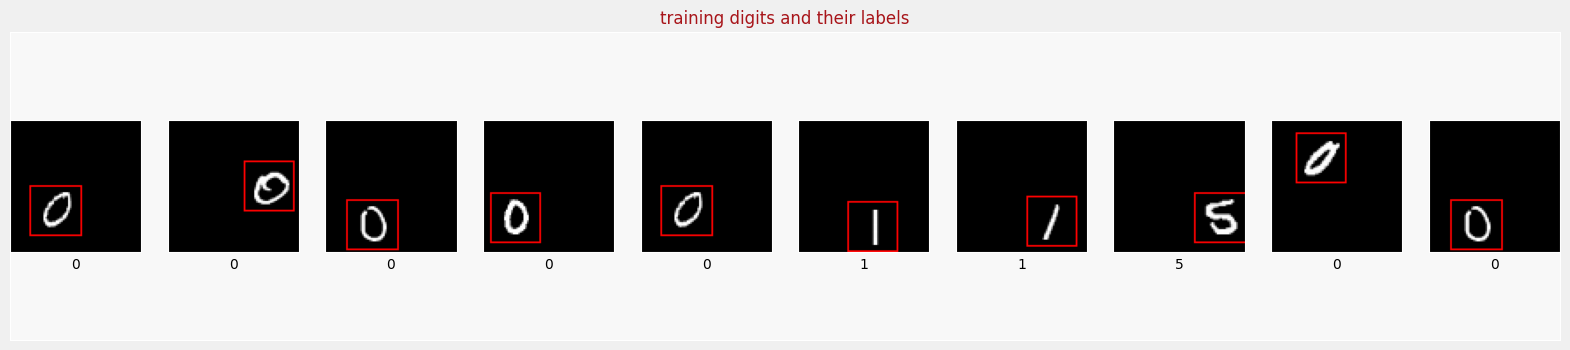

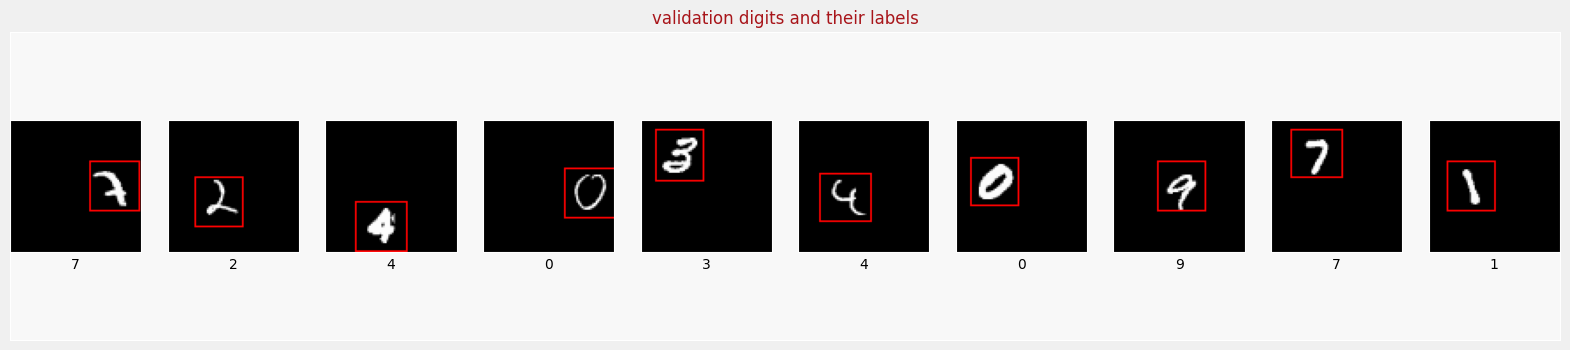

In [35]:
(training_digits,
 training_labels,
 training_bboxes,
 validation_digits,
 validation_labels,
 validation_bboxes) = dataset_to_numpy_util(
      training_dataset, validation_dataset, 10
 )

display_digits_with_boxes(
    training_digits,
    training_labels,
    training_labels,
    np.array([]),
    training_bboxes,
    np.array([]),
    "training digits and their labels"
)
display_digits_with_boxes(
    validation_digits,
    validation_labels,
    validation_labels,
    np.array([]),
    validation_bboxes,
    np.array([]),
    "validation digits and their labels"
)

In [37]:
def feature_extractor(inputs: tf.Tensor) -> tf.Tensor:
    '''
    Feature extractor is the CNN that is made up of convolution and pooling
    layers.
    '''
    x: tf.Tensor = tf.keras.layers.Conv2D(
        16, activation='relu', kernel_size=3, input_shape=(75, 75, 1)
    )(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    return x


In [38]:
def dense_layers(inputs: tf.Tensor) -> tf.Tensor:
    '''
    dense_layers adds a flatten and dense layer. This will follow the feature
    extraction layers
    '''
    x: tf.Tensor = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return x

In [39]:
def classifier(inputs: tf.Tensor) -> tf.Tensor:
    '''
    Classifier defines the classification output. This has a set of fully
    connected layers and a softmax layer.
    '''
    classification_output: tf.Tensor = tf.keras.layers.Dense(
        10, activation='softmax', name='classification'
    )(inputs)
    return classification_output

In [40]:
def bounding_box_regression(inputs: tf.Tensor) -> tf.Tensor:
    '''
    This function defines the regression output for bounding box prediction.
    Note that we have four outputs corresponding to (xmin, ymin, xmax, ymax)
    '''
    bounding_box_regression_output: tf.Tensor = tf.keras.layers.Dense(
        units='4', name='bounding_box'
    )(inputs)
    return bounding_box_regression_output

FINAL MODEL

In [41]:

def final_model(inputs: tf.Tensor) -> tf.keras.Model:
    feature_cnn: tf.Tensor = feature_extractor(inputs)
    dense_output: tf.Tensor = dense_layers(feature_cnn)

    '''
    The model branches here.
    The dense layer's output gets fed into two branches:
    classification_output and bounding_box_output
    '''
    classification_output: tf.Tensor = classifier(dense_output)
    bounding_box_output: tf.Tensor = bounding_box_regression(dense_output)

    model: tf.keras.Model = tf.keras.Model(
        inputs=inputs, outputs=[classification_output, bounding_box_output]
    )

    return model


In [42]:
def define_and_compile_model(inputs: tf.Tensor) -> tf.keras.Model:
    model: tf.keras.Model = final_model(inputs)

    model.compile(
        optimizer='adam',
        loss = {
            'classification' : 'categorical_crossentropy',
            'bounding_box' : 'mse'
        },
        metrics = {
            'classification' : 'accuracy',
            'bounding_box' : 'mse'
        }
    )
    return model

In [43]:


with strategy.scope():
    inputs: tf.keras.layers.Layer = tf.keras.layers.Input(shape=(75, 75, 1,))
    model: tf.keras.Model = define_and_compile_model(inputs)

# print model layers
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 73, 73, 16)           160       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 36, 36, 16)           0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 34, 34, 32)           4640      ['average_pooling2d[0][0]'

In [44]:
EPOCHS: int = 10 # 45
steps_per_epoch: int = 60000//BATCH_SIZE  # 60,000 items in this dataset
validation_steps: int = 1

history: tf.keras.callbacks.History = model.fit(
    training_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    epochs=EPOCHS
)

(loss,
 classification_loss,
 bounding_box_loss,
 classification_accuracy,
 bounding_box_mse) = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", classification_accuracy)

Epoch 1/10
937/937 [==============================] - 37s 31ms/step - loss: 0.9661 - classification_loss: 0.9500 - bounding_box_loss: 0.0160 - classification_accuracy: 0.6688 - bounding_box_mse: 0.0160 - val_loss: 0.3012 - val_classification_loss: 0.2926 - val_bounding_box_loss: 0.0086 - val_classification_accuracy: 0.9140 - val_bounding_box_mse: 0.0086
Epoch 2/10
937/937 [==============================] - 16s 17ms/step - loss: 0.2607 - classification_loss: 0.2544 - bounding_box_loss: 0.0063 - classification_accuracy: 0.9231 - bounding_box_mse: 0.0063 - val_loss: 0.1809 - val_classification_loss: 0.1767 - val_bounding_box_loss: 0.0042 - val_classification_accuracy: 0.9459 - val_bounding_box_mse: 0.0042
Epoch 3/10
937/937 [==============================] - 11s 11ms/step - loss: 0.1931 - classification_loss: 0.1892 - bounding_box_loss: 0.0039 - classification_accuracy: 0.9429 - bounding_box_mse: 0.0039 - val_loss: 0.1543 - val_classification_loss: 0.1508 - val_bounding_box_loss: 0.0035 -

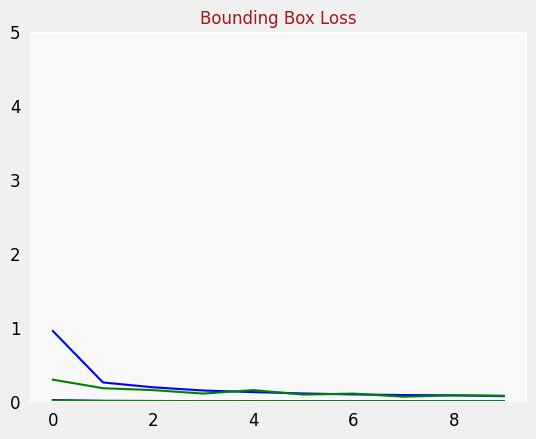

In [45]:
plot_metrics("classification_loss", "Classification Loss")
plot_metrics("bounding_box_loss", "Bounding Box Loss")

In [46]:
def intersection_over_union(pred_box: np.ndarray, true_box: np.ndarray):
    xmin_pred: np.ndarray
    ymin_pred: np.ndarray
    xmax_pred: np.ndarray
    ymax_pred: np.ndarray
    xmin_true: np.ndarray
    ymin_true: np.ndarray
    xmax_true: np.ndarray
    ymax_true: np.ndarray
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis=1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis=1)

    smoothing_factor: float = 1e-10

    xmin_overlap: np.ndarray = np.maximum(xmin_pred, xmin_true)
    xmax_overlap: np.ndarray = np.minimum(xmax_pred, xmax_true)
    ymin_overlap: np.ndarray = np.maximum(ymin_pred, ymin_true)
    ymax_overlap: np.ndarray = np.minimum(ymax_pred, ymax_true)

    pred_box_area: np.ndarray = (xmax_pred-xmin_pred) * (ymax_pred-ymin_pred)
    true_box_area: np.ndarray = (xmax_true-xmin_true) * (ymax_true-ymin_true)

    overlap_area: np.ndarray = (np.maximum((xmax_overlap-xmin_overlap), 0)  *
                                np.maximum((ymax_overlap-ymin_overlap), 0))
    union_area: np.ndarray = (pred_box_area+true_box_area) - overlap_area

    iou: np.ndarray = ((overlap_area+smoothing_factor) /
                       (union_area+smoothing_factor))

    return iou

157/157 [==============================] - 1s 3ms/step
Number of predictions where iou > threshold(0.6): 8966
Number of predictions where iou < threshold(0.6): 1034


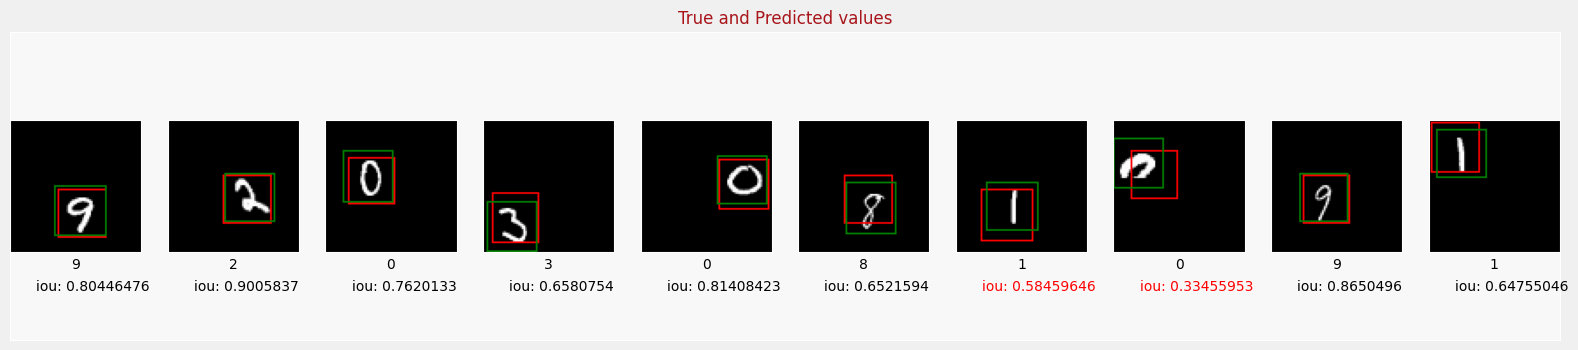

In [47]:
# recognize validation digits
predictions: list = model.predict(validation_digits, batch_size=64)
predicted_labels: np.ndarray = np.argmax(predictions[0], axis=1)

predicted_bboxes: np.ndarray = predictions[1]

iou: np.ndarray = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold: float = 0.6

g_prd: int = (iou >= iou_threshold).sum()
l_prd: int = (iou < iou_threshold).sum()
print(f"Number of predictions where iou > threshold({iou_threshold}): {g_prd}")
print(f"Number of predictions where iou < threshold({iou_threshold}): {l_prd}")


display_digits_with_boxes(
    validation_digits,
    predicted_labels,
    validation_labels,
    predicted_bboxes,
    validation_bboxes,
    iou,
    "True and Predicted values"
)